In [1]:
from astropy.io import fits
import jax
import jax.numpy as jnp
import sys

import os
import datetime
import glob
import h5py

sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import numpy as np

import astropy.coordinates as coord
import astropy.time as atime
import astropy.units as u

from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
files = glob.glob('/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/*.fits',recursive = True)

In [4]:
files

['/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:02:00.473.fits',
 '/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:02:25.933.fits',
 '/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:01:06.970.fits',
 '/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:05:30.797.fits',
 '/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:02:54.580.fits',
 '/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:01:49.317.fits',
 '/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:03:38.503.fits',
 '/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:00:47.097.fits',
 '/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:05:32.857.fits',
 '/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:05:21.843.fits',
 '/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-23T11:01:19.763.fits',

In [5]:
hdu1 = fits.open(files[0])

In [6]:
hdu1[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              5010272 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'WAVE    '                                                            
TFORM1  = '313142D '                                                            
EXTNAME = 'SPECTRUM'           / Extension Name                                 
DATASUM = '1250708763'         / data unit checksum updated 2014-09-17T01:06:36 
TTYPE2  = 'FLUX    '        

In [7]:
wave = np.array(hdu1[1].data['WAVE'])
flux = np.array(hdu1[1].data['FLUX'])
error = np.array(hdu1[1].data['ERR'])
print(flux.shape,error.shape)


(1, 313142) (1, 313142)


In [8]:
import jabble.physics
import astropy.coordinates as coord

In [9]:
coord.EarthLocation.get_site_names()

['ALMA',
 'ATST',
 'Anglo-Australian Observatory',
 'Apache Point',
 'Apache Point Observatory',
 'Atacama Large Millimeter Array',
 'BAO',
 'BBSO',
 'Beijing XingLong Observatory',
 'Big Bear Solar Observatory',
 'Black Moshannon Observatory',
 'CHARA',
 'Canada-France-Hawaii Telescope',
 'Catalina Observatory',
 'Catalina Observatory: 61 inch telescope',
 'Cerro Pachon',
 'Cerro Paranal',
 'Cerro Tololo',
 'Cerro Tololo Interamerican Observatory',
 'DCT',
 'DKIST',
 'Daniel K. Inouye Solar Telescope',
 'Discovery Channel Telescope',
 'Dominion Astrophysical Observatory',
 'G1',
 'GBT',
 'GEO',
 'GEO600 Gravitational Wave Detector',
 'GEO_600',
 'Gemini North',
 'Gemini South',
 'Green Bank Telescope',
 'H1',
 'Hale Telescope',
 'Haleakala Observatories',
 'Happy Jack',
 'IAO',
 'Indian Astronomical Observatory',
 'JCMT',
 'James Clerk Maxwell Telescope',
 'Jansky Very Large Array',
 'K1',
 'KAGRA',
 'Kamioka Gravitational Wave Detector',
 'Keck Observatory',
 'Kitt Peak',
 'Kitt Peak

In [10]:
xs = []
ys = []
yi = []
ma = []

mjds = []
ams = []
bcs = []

wave_min = 6500
wave_max = 6800
for file in files:
    try:
        hdu1 = fits.open(file)
        ams.append(np.double(hdu1[0].header['AIRMASS']))
        wave_temp = np.array(hdu1[1].data['WAVE']).flatten()
        wave_inds = (wave_temp > wave_min) * (wave_temp < wave_max)
        ys.append(np.log(np.array(hdu1[1].data['FLUX']).flatten()[wave_inds]))
        xs.append(np.log(wave_temp[wave_inds]))
        yi.append((np.array(hdu1[1].data['FLUX']).flatten()[wave_inds]/np.array(hdu1[1].data['ERR']).flatten()[wave_inds])**2)
        ma.append((np.array(hdu1[1].data['ERR']).flatten()[wave_inds] <= 0.0))
        mjds.append(np.double(hdu1[0].header['MJD-OBS']))
        
        bcs.append(jabble.physics.get_star_velocity(mjds[-1],hdu1[0].header['OBJECT'],'La Silla Observatory (ESO)').to(u.m/u.s).value)
    except:
        print(file)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "epv00" yielded 1 of "warning: date outsidethe range 1900-2100 AD"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "plan94" yielded 1 of "warning: year outside 1000-3000"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-26T16:51:33.687.fits
/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-26T16:54:15.103.fits
/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-26T16:53:12.300.fits
/scratch/mdd423/wobble_jax/data/sco18_HARPS/archive-2/ADP.2014-09-26T16:54:37.200.fits


In [11]:
np.array(hdu1[1].data['ERR']).flatten()

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [12]:
np.sum(np.isnan(np.concatenate(yi))),np.sum(np.concatenate(ma))

(5879804, 0)

In [13]:
len(mjds)

196

In [16]:
out_dir

'../out/24-01-10'

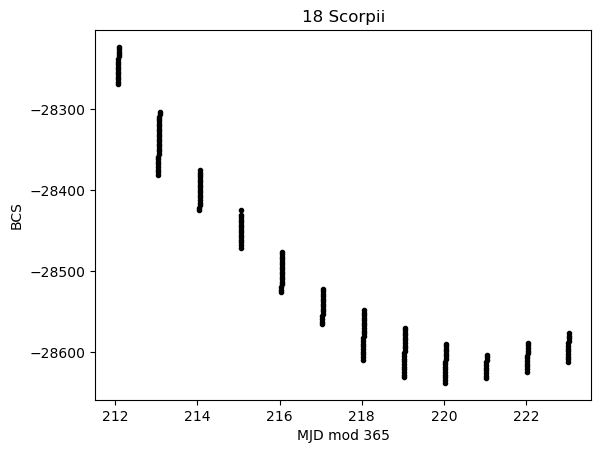

In [15]:
# bcs = [jabble.physics.get_star_velocity(time,hdu1[0].header['OBJECT'],'La Silla Observatory (ESO)').to(u.m/u.s).value for time in mjds]
plt.plot([mjd%365 for mjd in mjds],bcs,'.k')
plt.title('18 Scorpii')
plt.ylabel('BCS')
plt.xlabel('MJD mod 365')
plt.savefig(os.path.join(out_dir,'04-18sco-rv-mjd.png'))
plt.show()

In [17]:
460*np.cos(29/360*2*np.pi)

402.325065284122

In [18]:
hdu1[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
DATASUM = '0       '           / data unit checksum updated 2014-09-16T22:49:36 
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H   
DATE    = '2010-09-15T11:42:36.247' / Date this file was written                
INSTRUME= 'HARPS   '           / Instrument used                                
RA      =           243.899760 / 16:15:35.9 RA (J2000) pointing                 
DEC     =             -8.37150 / -08:22:17.4 DEC (J2000) pointing               
EQUINOX =                2000. / Standard FK5 (years)                           
RADECSYS= 'FK5     '        

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


<ErrorbarContainer object of 3 artists>

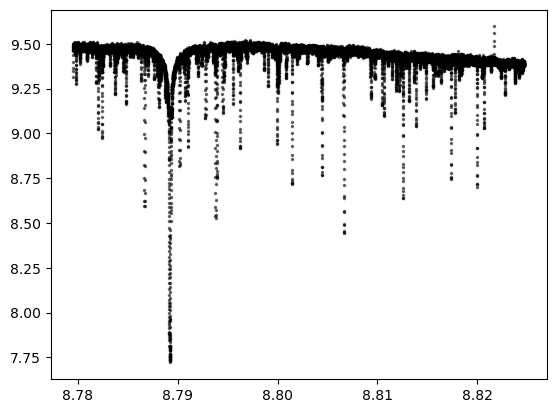

In [19]:
plt.errorbar(xs[0],ys[0],1/np.sqrt(yi[0]),fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

In [20]:
import jabble.loss
import jabble.dataset
import jabble.model
import jabble.physics
from dataclasses import dataclass

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [21]:
@dataclass
class Data:
    """Temporary Data Type"""
    xs: list
    ys: list
    yivar: list
    mask: list

    def __getitem__(self,i):
        return Data([self.xs[i]],[self.ys[i]],[self.yivar[i]],[self.mask[i]])

    @property
    def yerr(self):
        return 1/np.sqrt(self.yivar)

class MyChi(jabble.loss.ChiSquare):
    def loss_all(self,p,data,model,*args):
        output = 0.0
        # recall ys are packed st that 0: epoches, 1: pixel
        # if model.save_historyle:
        #     loss_arr = np.zeros(data.ys.shape)
        for ind in range(len(data.ys)):

            output += self(p,data,ind,model,*args).sum()
        # if model.save_history:
        #     model.chi_history.append(loss_arr)
        return output

    def __call__(self, p, data, i, model, *args):
        err = self.coefficient * (((data.ys[i][~data.mask[i]] - model(p,data.xs[i][~data.mask[i]],i,*args))**2))
        return err

In [22]:
class NormalizationModel(jabble.model.ContainerModel):
    def get_indices(self,i):
        return np.arange(
                    np.sum(self.parameters_per_model[:i]),
                    np.sum(self.parameters_per_model[: i + 1]),
                    dtype=int,
                )
    
    def call(self, p, x, i, *args):
        indices = self.get_indices(i)
        x = self.models[i](p[indices], x, i, *args)
        return x

In [23]:
data = Data(xs,ys,yi,ma)
loss = MyChi()

In [24]:
def get_model(dataset,resolution,p_val,vel_padding,init_shifts,airmass):
    # dx = jabble.physics.delta_x(2 * resolution)
    # x_grid = np.arange(np.min(xs), np.max(xs), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        np.concatenate(dataset.xs), vel_padding, 2 * resolution
    )  
    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts),
            jabble.model.IrwinHallModel_vmap(model_grid, p_val),
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.IrwinHallModel_vmap(model_grid, p_val),
            jabble.model.StretchingModel(airmass),
        ]
    )

    return model

def get_norm_model(pts_per_wavelength,norm_p_val,p_val,data,resolution,vel_padding,init_shifts,airmass):
    xs = np.concatenate(data.xs)
    model_list = [jabble.model.IrwinHallModel_vmap(\
        np.linspace(np.min(xs),np.max(xs),\
                    int((np.exp(np.max(xs)) - np.exp((np.min(xs)))) * pts_per_wavelength)\
                   ), norm_p_val) for xs in data.xs]
    norm_model = NormalizationModel(model_list) + get_model(data,resolution,p_val,vel_padding,init_shifts,airmass)
    return norm_model

In [25]:
norm_p_val = 4
p_val = 3
resolution = 120_000

init_shifts = jabble.physics.shifts(np.array(bcs))
vel_padding = 60_000

norm_pts = [1/100]
norm_models = [get_norm_model(pts_per_wavelength,norm_p_val,p_val,data,resolution,vel_padding,init_shifts,ams) for pts_per_wavelength in norm_pts]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [26]:
data.mask[5].shape

(29999,)

In [27]:
norm_models[0].display()

-AdditiveModel------------------------------------0
  0-NormalizationModel---------------------------------------------0
  0  0-IrwinHallModel_vmap-----------------------------------------0
  0  1-IrwinHallModel_vmap-----------------------------------------0
  0  2-IrwinHallModel_vmap-----------------------------------------0
  0  3-IrwinHallModel_vmap-----------------------------------------0
  0  4-IrwinHallModel_vmap-----------------------------------------0
  0  5-IrwinHallModel_vmap-----------------------------------------0
  0  6-IrwinHallModel_vmap-----------------------------------------0
  0  7-IrwinHallModel_vmap-----------------------------------------0
  0  8-IrwinHallModel_vmap-----------------------------------------0
  0  9-IrwinHallModel_vmap-----------------------------------------0
  0  10-IrwinHallModel_vmap----------------------------------------0
  0  11-IrwinHallModel_vmap----------------------------------------0
  0  12-IrwinHallModel_vmap------------------------

In [28]:
def fit_cycle(model,loss,data):

    model.fix()
    model.fit(0)
    res = model.new_lbfgsb(loss, data)
    print(res)
    
    model.fix()
    model.fit(1,0,1)
    model.fit(1,1,0)
    res = model.new_lbfgsb(loss, data)
    print(res)

    model.fix()
    model.fit(1,0,0)
    # model.fit(1,1,1)
    res = model.new_lbfgsb(loss, data)
    print(res)

    model.fix()
    model.fit(0)
    model.fit(1,0,0)
    model.fit(1,0,1)
    model.fit(1,1,0)
    res = model.new_lbfgsb(loss, data)
    print(res)
    return model

In [29]:
len(data.xs),len(init_shifts),len(data.ys)

(196, 196, 196)

In [30]:
import cProfile

In [31]:
statsname = '18scostats.stat'
for norm_model in norm_models:
    cProfile.run('fit_cycle(norm_model,loss,data)',statsname)

{'grad': array([7.08637432, 0.56713463, 6.46966447, 0.47406871, 6.59665601,
       0.57630126, 7.26400857, 0.52400826, 6.85061486, 0.57524733,
       7.03398958, 0.66129373, 7.24204387, 0.59475713, 6.44004475,
       0.47284847, 6.80014958, 0.55570099, 7.05495369, 0.68624878,
       6.78884738, 0.58098936, 6.5831013 , 0.48697914, 6.80831539,
       0.53955075, 6.79628894, 0.64356924, 6.51215558, 0.48136465,
       7.30575134, 0.62134388, 7.15722423, 0.62587102, 6.96202025,
       0.59814311, 7.07435876, 0.6224275 , 6.78029167, 0.55690507,
       7.31650065, 0.60526097, 7.38564498, 0.63464167, 6.3910884 ,
       0.4780946 , 7.15929205, 0.69069815, 6.61406089, 0.53998202,
       6.99741826, 0.68091082, 7.31445858, 0.61545937, 7.12662775,
       0.53798548, 6.77245539, 0.54951118, 7.13931109, 0.60723595,
       7.11071853, 0.50892912, 6.54406563, 0.49906872, 6.69777877,
       0.56884257, 6.80627152, 0.58132139, 7.21868961, 0.68286636,
       7.16690063, 0.65548091, 6.05727676, 0.46695659

In [32]:
def make_norm_plot(model,dataset,plt_epoches,lmin,lmax,lrange,plt_name):
    fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),8),sharex=True,sharey='row',facecolor=(1, 1, 1),dpi=200)
    
    x_window = np.log(4550) - np.log(4549)
    
    model.fix()
    for ii, plt_epoch in enumerate(plt_epoches):
        xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs[plt_epoch].shape[0]*10)
        yplot = model[0]([],xplot,plt_epoch)
        yplot_norm_tell = model[1][1]([],xplot,plt_epoch)
        yplot_norm_stel = model[1][0]([],xplot,plt_epoch)
        yhat = model[0]([],dataset.xs[plt_epoch],plt_epoch)
        axes[0,ii].set_xlim(xplot.min(),xplot.max())
        
        
    
        
        axes[0,ii].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:],\
                                 dataset[plt_epoch].yerr,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
        
        axes[0,ii].plot(xplot,yplot,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
     
        axes[1,ii].errorbar(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - yhat,\
                                 dataset[plt_epoch].yerr,fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

        # axes[1,ii].plot(gas_xs,gas_ys,'-g',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        
        axes[1,ii].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        axes[1,ii].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        axes[0,ii].set_xticks([])
        axes[1,ii].set_xticks(np.log(lrange))
        axes[1,ii].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        # axes[0,ii].set_ylims()
        # axes[1,ii].plot(dataset.xs[plt_epoch][:],dataset.ys[plt_epoch][:] - model([],dataset.xs[plt_epoch][:],plt_epoch),'.k',alpha=0.4,ms=1)
        
    fig.text(0.5, 0.04, '$\lambda$', ha='center')
    plt.savefig(plt_name,dpi=300,bbox_inches='tight')
    plt.show()

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


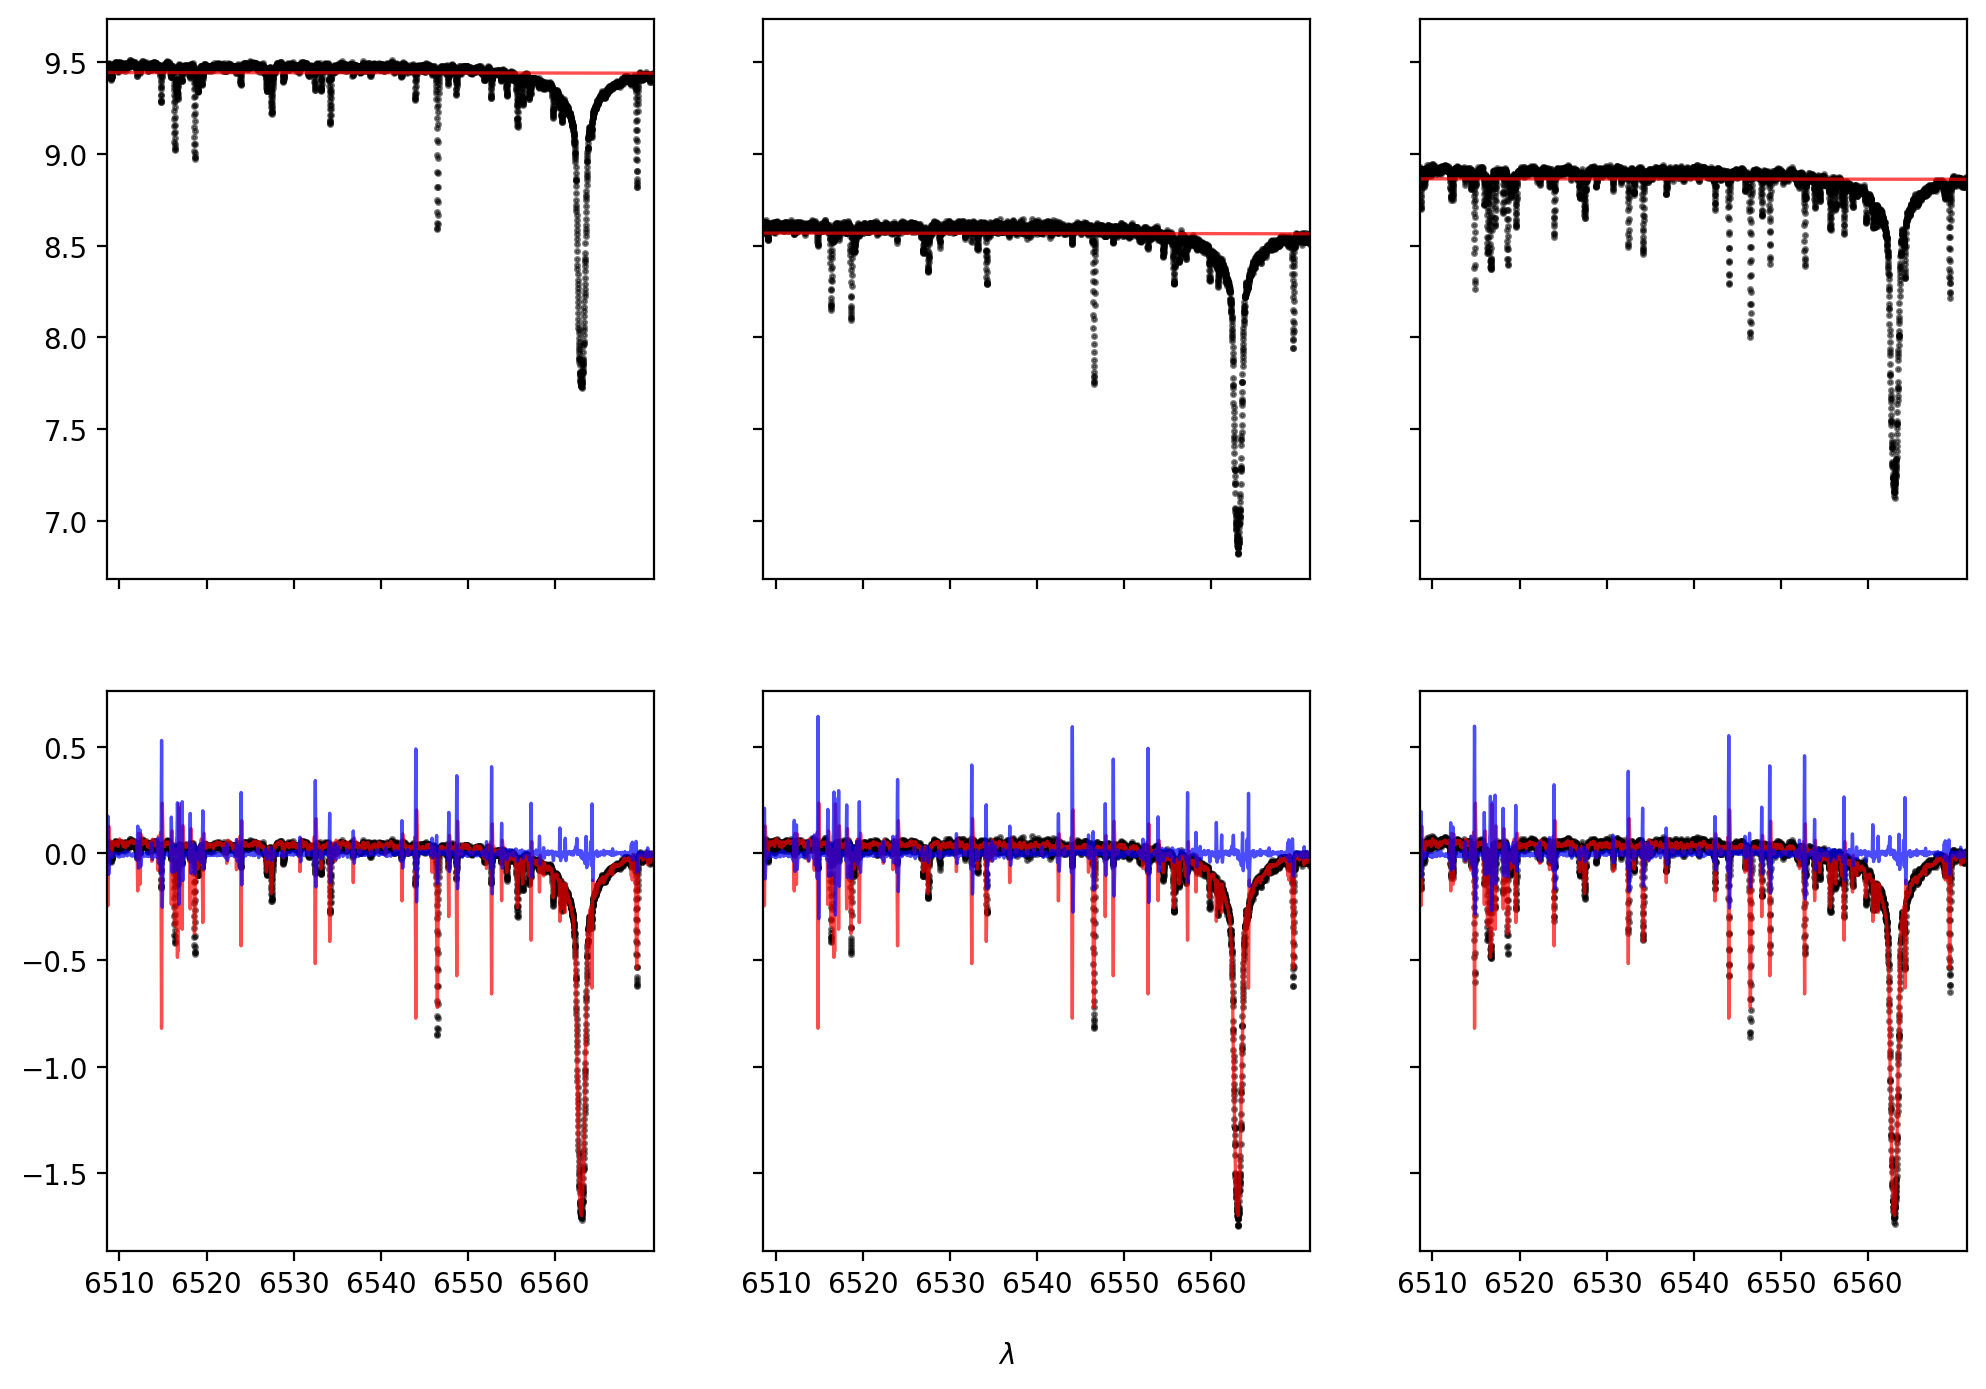

In [33]:
plt_epoches= [0,1,2]
lmin = np.exp(data.xs[0][1000])
lmax = np.exp(data.xs[0][7000])
lrange = np.arange(lmin,lmax,10)
plt_names = [os.path.join(out_dir,'04-18sco-norm-stel-tell-{}_{}-npt{}.png'.format(np.min(lrange),np.max(lrange),norm_pt))
    for norm_pt in norm_pts]
for norm_model,plt_name in zip(norm_models,plt_names):
    make_norm_plot(norm_model,data,plt_epoches,lmin,lmax,lrange,plt_name)

In [34]:
9999*196

1959804

In [35]:
p = pstats.Stats(statsname)
p.sort_stats(SortKey.TIME).print_stats(10)

NameError: name 'pstats' is not defined